# Multiturn Conversation using Interrupt

In [11]:
from langgraph.graph import add_messages, StateGraph, END, START
from langgraph.types import Command, interrupt
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_groq import ChatGroq
import uuid
from dotenv import load_dotenv

load_dotenv()
 

True

In [12]:
llm = ChatGroq(model="llama3-70b-8192")

class State(TypedDict):
    linkedin_topic: str
    generated_post: Annotated[List[str], add_messages]
    human_feedback: Annotated[List[str], add_messages]

In [13]:
def model(state:State)-> State:
    """ Here' we're using the LLM to generate a LinkedIn post with human feedback incorporated"""

    print("[model] Generating Content")
    linkedin_topic = state["linkedin_topic"]
    feedback = state["human_feedback"] if "human_feedback" in state else ["No Feedback yet"]

    # "Here, we define the prompt"
    
    prompt= f"""
LinkedIn Topic : {linkedin_topic}
Human Feeback: {feedback[-1] if feedback else "no feedback yet"} 
Generate a structured and well-written LinkedIn post based on the given topic.

Consider previous human feedback t refine the response
"""

    response = llm.invoke([
        SystemMessage(content="you are an expert LinkedIn content writer"),
        HumanMessage(content=prompt)
    ])

    generated_linkedin_post= response.content

    print(f"[model_node] Generated post: \n {generated_linkedin_post }")

    return {
        "generated_post":[AIMessage(content=generated_linkedin_post)],
        "human_feedback": feedback
    }


In [14]:
def human_node(state:State):
    """ Human Intervention node - loops back to model unless input is done"""

    print("\n [human_node] awaiting human feedback...")
    generated_post = state['generated_post']

    #Interrupt to get user feeback

    user_feedback = interrupt(
        {
            "generated_post": generated_post,
            "message":"Provide feedback or type 'done' to finish    "
        }
    )

    print(f"[human_node] Retrieve human feeback: {user_feedback}")

    #if user types "done", transition to END node 
    if user_feedback.lower()=="done":
        return Command(
            update={"human_feedback":state["human_feedback"]},
            goto = "end_node"
        )
    
    #otherwise, feedback and return to model for re-generation
    return Command(
        update={"human_feedback":state['human_feedback'] + [user_feedback]},
        goto ="model"
    )

In [15]:
def end_node(state:State):
    """Final node"""

    print("\n [end_node] process finished")
    print("Final Generated Post:", state["generated_post"][-1])
    print("Final Human Feedback",state["human_feedback"])
    return {
        "generated_post": state["generated_post"],
        "human_feedback": state["human_feedback"]
    }

In [16]:
graph = StateGraph(State)

graph.add_node("model", model)
graph.add_node("human_node", human_node)
graph.add_node("end_node", end_node)

# Defin the flow

graph.add_edge(START, "model")
graph.add_edge("model", "human_node")
graph.add_edge("end_node", END)

#Enable Interrupt mechanism
checkpointer=MemorySaver()
app = graph.compile(checkpointer=checkpointer)

thread_config = {"configurable":{
    "thread_id": uuid.uuid4()
}}

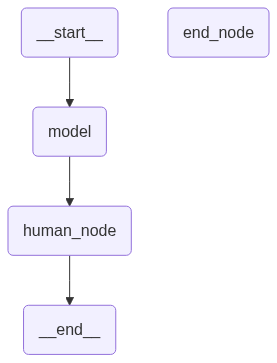

In [17]:
app

In [18]:
input

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000024A57DA0BE0>>

In [19]:
linkedin_topic = input("Enter your LinkedIn topic: ")

initial_state = {
    "linkedin_topic": linkedin_topic,
    "generated_post": [],
    "human_feedback": []
}

Enter your LinkedIn topic:  story about lagos


In [20]:
for chunk in app.stream(initial_state, config=thread_config):
    for node_id, value in chunk.items():
        # if we reach an interrupt, continously ask for human feedback

        if(node_id=="__interrupt__"):
            while True:
                user_feedback = input("Provide feedback (or type 'done' when finished): ")

                # resume the graph executioin with the user's feedback
                app.invoke(
                    Command(resume=user_feedback),
                    config=thread_config
                )

                # Exit loop if user says done
                if user_feedback.lower() == "done":
                    break


[model] Generating Content
[model_node] Generated post: 
 Here's a structured and well-written LinkedIn post on the topic "Story about Lagos":

**Title:** The Unbridled Energy of Lagos: A City That Never Sleeps

**Introduction:**
Have you ever wondered what it's like to be in a city that pulsates with energy 24/7? A city where the sound of honking horns, chatter, and music is the constant hum of activity? Welcome to Lagos, the vibrant metropolis of Nigeria, where the rhythm of life is fast-paced and infectious!

**The Story:**
As I stepped off the plane and into the bustling streets of Lagos, I was immediately struck by the sheer scale and complexity of this megacity. From the towering skyscrapers of Victoria Island to the colorful markets of Balogun, every corner of Lagos tells a story of resilience, innovation, and creativity.

I recall my first encounter with the legendary Lagos traffic, which tested my patience but also showcased the city's entrepreneurial spirit. From street vendo

Provide feedback (or type 'done' when finished):  can you make it only two paragraph of the story



 [human_node] awaiting human feedback...
[human_node] Retrieve human feeback: can you make it only two paragraph of the story
[model] Generating Content
[model_node] Generated post: 
 Here's a two-paragraph story about Lagos:

As I stepped off the plane in Lagos, Nigeria, I was hit with a wave of energy that was both overwhelming and exhilarating. The sounds, the smells, the vibrant colors – everything about this city seemed to pulse with a rhythm that was uniquely its own. From the crowded streets of Victoria Island to the bustling markets of Lagos Island, every moment in this city felt like a sensory overload in the best possible way. And yet, amidst the chaos, I found a sense of community and warmth that I'd never experienced before. Strangers became friends over plates of jollof rice and suya, and the city's infectious energy soon had me dancing to the beat of Afrobeats in the streets.

But Lagos is more than just a city – it's a state of mind. It's a place where resilience and de

Provide feedback (or type 'done' when finished):  make it funny



 [human_node] awaiting human feedback...
[human_node] Retrieve human feeback: make it funny
[model] Generating Content
[model_node] Generated post: 
 Here's a humorous take on a story about Lagos, tailored to the LinkedIn audience:

**Title:** "Lagos: Where Hustle Meets Chaos (And a Little Bit of Magic)"

**Post:**

"Ah, Lagos - the city that will drive you crazy, test your patience, and somehow, still make you fall in love with it.

As a [Your Profession/Industry], I've had the privilege of navigating the streets of Lagos, where the phrase 'hustle and bustle' takes on a whole new meaning. From the infamous traffic jams that'll make you question your life choices, to the vibrant markets that'll make you want to shop 'til you drop (your wallet, that is), Lagos is a city that's equal parts exhausting and exhilarating.

But what really gets me is the resilience of the Lagosians. These are people who can turn a 3-hour traffic jam into a mobile party, complete with impromptu dance sessions

Provide feedback (or type 'done' when finished):  done



 [human_node] awaiting human feedback...
[human_node] Retrieve human feeback: done

 [end_node] process finished
Final Generated Post: content='Here\'s a humorous take on a story about Lagos, tailored to the LinkedIn audience:\n\n**Title:** "Lagos: Where Hustle Meets Chaos (And a Little Bit of Magic)"\n\n**Post:**\n\n"Ah, Lagos - the city that will drive you crazy, test your patience, and somehow, still make you fall in love with it.\n\nAs a [Your Profession/Industry], I\'ve had the privilege of navigating the streets of Lagos, where the phrase \'hustle and bustle\' takes on a whole new meaning. From the infamous traffic jams that\'ll make you question your life choices, to the vibrant markets that\'ll make you want to shop \'til you drop (your wallet, that is), Lagos is a city that\'s equal parts exhausting and exhilarating.\n\nBut what really gets me is the resilience of the Lagosians. These are people who can turn a 3-hour traffic jam into a mobile party, complete with impromptu da